In [25]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [26]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [28]:
# Load the Data

# Set train and test directory paths

dataset = '/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

2
{0: 'bad', 1: 'good'}


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size,  test_data_size)

660 440


In [30]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

/home/mayooran/anaconda3/envs/patch_core_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mayooran/anaconda3/envs/patch_core_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [32]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [34]:
# Define Optimizer and Loss Function
#loss_func = nn.NLLLoss()
loss_func=BinaryFocalLoss()
optimizer = optim.Adam(resnet50.parameters())

In [35]:
def train(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            labels_one_hot=nn.functional.one_hot(labels,num_classes=2)
            # Compute loss
            loss = loss_criterion(outputs, labels_one_hot.float())

            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
       
        if train_loss < best_loss:
            best_loss = train_loss
            best_epoch = epoch


        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        history.append([avg_train_loss, avg_train_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\t Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_FocalLoss_withSGD_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [73]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 80
trained_model, history, best_epoch = train(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/80
Epoch : 000, Training: Loss - 0.2223, Accuracy - 91.6667%, 
		 Time: 12.7420s
Epoch: 2/80
Epoch : 001, Training: Loss - 0.2044, Accuracy - 91.2121%, 
		 Time: 12.3627s
Epoch: 3/80
Epoch : 002, Training: Loss - 0.2338, Accuracy - 90.9091%, 
		 Time: 12.3846s
Epoch: 4/80
Epoch : 003, Training: Loss - 0.2071, Accuracy - 91.9697%, 
		 Time: 12.4756s
Epoch: 5/80
Epoch : 004, Training: Loss - 0.2085, Accuracy - 92.4242%, 
		 Time: 12.6231s
Epoch: 6/80
Epoch : 005, Training: Loss - 0.1711, Accuracy - 92.4242%, 
		 Time: 12.6620s
Epoch: 7/80
Epoch : 006, Training: Loss - 0.1896, Accuracy - 92.4242%, 
		 Time: 12.4339s
Epoch: 8/80
Epoch : 007, Training: Loss - 0.2069, Accuracy - 90.6061%, 
		 Time: 12.4035s
Epoch: 9/80
Epoch : 008, Training: Loss - 0.2072, Accuracy - 92.2727%, 
		 Time: 12.3439s
Epoch: 10/80
Epoch : 009, Training: Loss - 0.1910, Accuracy - 92.2727%, 
		 Time: 12.4137s
Epoch: 11/80
Epoch : 010, Training: Loss - 0.2078, Accuracy - 92.1212%, 
		 Time: 12.3798s
Epoch: 1

In [37]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            labels_one_hot=nn.functional.one_hot(labels,num_classes=2)
    
            # Compute loss
            loss=loss_criterion(outputs, labels_one_hot.float())

            

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            #print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [ ]:
best_epoch

In [38]:
#computeTestSetAccuracy(trained_model,loss_func)
computeTestSetAccuracy(torch.load("/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle_model_FocalLoss_79.pt"),loss_func)

Test accuracy : 0.9340909090909091


In [77]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        print(ps)

        topk, topclass = ps.topk(1, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(1):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

tensor([[0.1433, 0.8567]], device='cuda:0')
Predcition 1 : good , Score:  0.8567335
tensor([[0.3415, 0.6585]], device='cuda:0')
Predcition 1 : good , Score:  0.6585323
tensor([[0.5038, 0.4962]], device='cuda:0')
Predcition 1 : bad , Score:  0.5038418
tensor([[0.6050, 0.3950]], device='cuda:0')
Predcition 1 : bad , Score:  0.6050068
tensor([[0.7530, 0.2470]], device='cuda:0')
Predcition 1 : bad , Score:  0.75304973
tensor([[0.6369, 0.3631]], device='cuda:0')
Predcition 1 : bad , Score:  0.6369012
tensor([[0.2999, 0.7001]], device='cuda:0')
Predcition 1 : good , Score:  0.70013386
tensor([[0.0057, 0.9943]], device='cuda:0')
Predcition 1 : good , Score:  0.99427867
tensor([[0.8372, 0.1628]], device='cuda:0')
Predcition 1 : bad , Score:  0.8371864
tensor([[0.4505, 0.5495]], device='cuda:0')
Predcition 1 : good , Score:  0.5495466
tensor([[0.1183, 0.8817]], device='cuda:0')
Predcition 1 : good , Score:  0.8817433
tensor([[0.0513, 0.9487]], device='cuda:0')
Predcition 1 : good , Score:  0.94

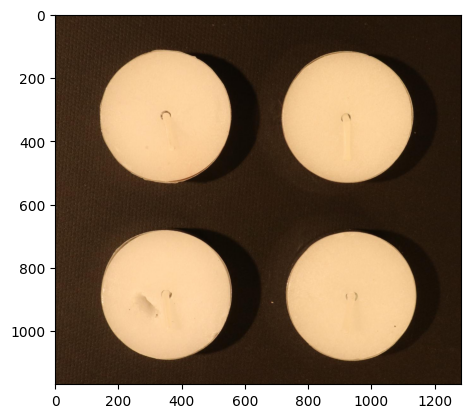

In [112]:
# Test a particular model on a test image
dataset = '/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle'
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))

files=os.listdir('/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle/test/bad/')
for file in files:
    predict(model, f'/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle/test/bad/{file}')


In [18]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import copy
import cv2
import joblib
import numpy as np
import skimage.measure as measure
import sklearn.metrics as metrics
import torch


def compute_classification_metrics(
    anomaly_scores,
    ground_truth_labels
):
    """
    Computes classification metrics (AUROC, FPR, TPR).
    Args:
        anomaly_scores: [np.array or list] [N] Anomaly scores.
         Higher indicates higher probability of being an anomaly.
        ground_truth_labels: [np.array or list] [N] Binary labels:
        1 if image is an anomaly, 0 if normal.
    """
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_labels,
                                             anomaly_scores)
    auroc = metrics.roc_auc_score(ground_truth_labels,
                                  anomaly_scores)

    precision, recall, thresholds = metrics.precision_recall_curve(np.array(ground_truth_labels), np.array(anomaly_scores))
    au_pr = metrics.auc(recall, precision)
    return {'auroc': auroc, 'fpr': fpr, 'tpr': tpr, 'threshold': thresholds, 'au_pr': au_pr}

In [53]:
  def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ground_truth_labels=[]
    anomaly_scores=[]
    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            ps = torch.exp(outputs)

            ground_truth_labels.append(labels.tolist())
            anomaly_scores.append(ps.tolist())

            
            labels_one_hot=nn.functional.one_hot(labels,num_classes=2)
    
            # Compute loss
            loss=loss_criterion(outputs, labels_one_hot.float())
            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            #print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))
    return ground_truth_labels, anomaly_scores

In [54]:
#ground_truth_labels,anomaly_scores=computeTestSetAccuracy(trained_model,loss_func)
ground_truth_labels,anomaly_scores=computeTestSetAccuracy(torch.load("/home/mayooran/mugunthan/VisA_paper/spot-diff/VisA_2cls_highshot/2cls_highshot/candle_model_79.pt"),loss_func)

Test accuracy : 0.9386363647200845


In [55]:
(ground_truth_labels)

[[1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,

In [51]:
ground_truth_labels = [1-j for sub in ground_truth_labels for j in sub]
anomaly_scores = [j[0] for sub in anomaly_scores for j in sub]

In [71]:
len(anomaly_scores)

440

In [52]:
compute_classification_metrics(
    anomaly_scores,
    ground_truth_labels
)

{'auroc': 0.9244375,
 'fpr': array([0.    , 0.    , 0.    , 0.0025, 0.0025, 0.005 , 0.005 , 0.0075,
        0.0075, 0.01  , 0.01  , 0.015 , 0.015 , 0.0175, 0.0175, 0.0225,
        0.0225, 0.0275, 0.0275, 0.03  , 0.03  , 0.0325, 0.0325, 0.0425,
        0.0425, 0.09  , 0.09  , 0.095 , 0.095 , 0.1025, 0.1025, 0.1225,
        0.1225, 0.225 , 0.225 , 0.235 , 0.235 , 0.35  , 0.35  , 0.385 ,
        0.385 , 0.715 , 0.715 , 1.    ]),
 'tpr': array([0.   , 0.025, 0.125, 0.125, 0.175, 0.175, 0.375, 0.375, 0.45 ,
        0.45 , 0.475, 0.475, 0.525, 0.525, 0.575, 0.575, 0.625, 0.625,
        0.65 , 0.65 , 0.675, 0.675, 0.725, 0.725, 0.75 , 0.75 , 0.775,
        0.775, 0.8  , 0.8  , 0.825, 0.825, 0.85 , 0.85 , 0.875, 0.875,
        0.9  , 0.9  , 0.95 , 0.95 , 0.975, 0.975, 1.   , 1.   ]),
 'threshold': array([1.26949431e-06, 6.18412832e-06, 7.23714538e-06, 7.92115407e-06,
        9.98666019e-06, 1.15754401e-05, 1.20112354e-05, 1.30487197e-05,
        1.49505049e-05, 1.49549260e-05, 1.87605947e-05, 